In [19]:
## data handling 
import numpy as np
import pandas as pd
import random

## plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## ML things
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
import functions as func

## comfort things
from typing import Tuple
from sys import exit

### **Loading of the datasets** 

In [20]:
coordinates_pred = pd.read_csv("data/Coordinates_Test.csv")
coordinates_train = pd.read_csv("data/Coordinates_Training.csv")
humidity_pred = pd.read_csv("data/Test_Time_humidity.csv")
humidity_train = pd.read_csv("data/Training_data_humidity.csv")
pressure_pred = pd.read_csv("data/Test_Time_pressure.csv")
pressure_train = pd.read_csv("data/Training_data_pressure.csv")
temperature_train = pd.read_csv("data/Training_data_temperature.csv")

In [21]:
imputer = KNNImputer(missing_values = np.nan, n_neighbors=2).set_output(transform="pandas")

## The imputer actually deletes columns with no data so we need to identify the columns with no data first
## We need to know those sensors to remove the associated data in the other dataframes. 
## It is needed because the values are only linked by having the same index in all dataframes.

train_faulty_sensors = []
for sensor in pressure_train.columns[1:]:
    if temperature_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif pressure_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif humidity_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
print(f'Faulty sensors in train datasets: {train_faulty_sensors}')

test_faulty_sensors = []
for sensor in pressure_pred.columns[1:]:
    if pressure_pred[sensor].isna().all():
        test_faulty_sensors.append(sensor)
    elif humidity_pred[sensor].isna().all():
        test_faulty_sensors.append(sensor)
print(f'Faulty sensors in prediction datasets: {test_faulty_sensors}')
# Actually no sensors in the test dataset has no data

## Deleting the corresponding entries in all training datasets:
# we have to work with indices when dealing with rows...
# used ChatGPT to get this heavy syntax and might not be efficient...
 
## We will remove the corresponding data as it's only 3 points. 
## But keep the coordinates of the faulty sensor so we have a 
# pressure_train.drop(train_faulty_sensors, axis=1, inplace=True)
# humidity_train.drop(train_faulty_sensors, axis=1, inplace=True)
# temperature_train.drop(train_faulty_sensors, axis=1, inplace=True)

## We need to impute the missing values with a KNN imputer so it can be plotted a first time: 
## Which requires renaming the columns: 

## Not keeping useless columns:
coordinates_train = coordinates_train[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
coordinates_pred = coordinates_pred[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
# The sensor ID will be usefull to group the data into a numpy array

# changing the column names for faster typing later
new_col_names: dict = {
    "Sensor ID": "id",
    "Coor X [m]": "x",
    "Coor Y [m]": "y",
    "Coor Z [m]": "z",
    "R [m]": "r"
}

coordinates_train.rename(columns = new_col_names, inplace=True)
coordinates_pred.rename(columns = new_col_names, inplace=True)

pressure_train = func.fill_NaN_columns(
    K = 5,
    df = pressure_train,
    imputer = imputer,
    coords = coordinates_train
)

pressure_pred = func.fill_NaN_columns(
    K = 5,
    df = pressure_pred,
    imputer = imputer,
    coords = coordinates_pred
)




Faulty sensors in train datasets: ['N_442', 'N_518', 'N_693']
Faulty sensors in prediction datasets: []


In [22]:

## One-hot encoding:
## cf intro to pandas notebook from the weekly exercises
coordinates_pred = pd.get_dummies(coordinates_pred, columns = ["Material"]) 
coordinates_train = pd.get_dummies(coordinates_train, columns = ["Material"]) 
display(coordinates_pred.head(5))
display(coordinates_train.head(5))

## the coordinates_pred is missing the columns "Material_BBLOCK" and "Material_VOID" that we have to add 
# Make a copy to be safe
df = coordinates_pred.copy()
# Create the new column with default value (e.g., 0 or NaN)
df["Material_BBLOCK"] = False  # or use np.nan if needed
df["Material_VOID"] = False
# Get column list and rearrange
cols = df.columns.tolist()
# Find index of "r"
r_index = cols.index("r")
# Insert "Material_BBLOCK" right after "r"
cols.insert(r_index + 1, cols.pop(cols.index("Material_BBLOCK")))
# Reorder the DataFrame
coordinates_pred = df[cols]


,id,x,y,z,r,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR
0,N_901,0.295918,30.011150,1.776254,1.800735,False,False,False,True,False
1,N_902,2.274456,25.204297,2.957595,3.731021,False,False,False,True,False
2,N_903,-0.586165,27.600980,-1.869516,1.959255,False,False,False,True,False
3,N_904,-1.680052,40.394076,-0.297226,1.706142,False,True,False,False,False
4,N_905,2.840656,38.093588,2.125899,3.548066,False,False,False,True,False


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_1,0.208042,14.436936,-2.875503,2.883019,False,False,False,False,True,False,False
1,N_2,-8.970832,28.229841,-0.134437,8.971839,False,False,False,False,True,False,False
2,N_3,-14.289501,6.685726,-10.399048,17.672862,False,False,False,False,True,False,False
3,N_4,6.114855,2.685645,-3.189981,6.896914,False,False,False,False,True,False,False
4,N_5,4.048845,48.708590,11.260503,11.966289,False,False,False,False,True,False,False


In [23]:

## clearing values below -3'000:
pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] <= 500, np.nan) ##-300 initially
pressure_pred.iloc[:,1:] = pressure_pred.iloc[:,1:].mask(pressure_pred.iloc[:,1:] <= 500, np.nan)

## Initial shapes
print("pressure_train shape:"+str(pressure_train.shape))
print("pressure_pred shape:"+str(pressure_pred.shape))

## Checking how many columns are filled with NaN values
count = pressure_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')
count = pressure_pred.isnull().all().sum()
print(f'{count} columns in pressure_pred are filled with NaN')

## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
pressure_train = func.fill_NaN_columns(
    K = 5,
    df = pressure_train,
    imputer = imputer,
    coords = coordinates_train
)

pressure_pred = func.fill_NaN_columns(
    K = 5,
    df = pressure_pred,
    imputer = imputer,
    coords = coordinates_pred
)

## Imputing missing values (if there are some):
pressure_train = (imputer.fit_transform(pressure_train.T)).T
pressure_pred = (imputer.fit_transform(pressure_pred.T)).T

## New shapes (should be the same)
print("pressure_train shape:"+str(pressure_train.shape))
print("pressure_pred shape:"+str(pressure_pred.shape))


pressure_train shape:(32, 901)
pressure_pred shape:(32, 146)
242 columns in pressure_train are filled with NaN
72 columns in pressure_pred are filled with NaN
pressure_train shape:(32, 901)
pressure_pred shape:(32, 146)


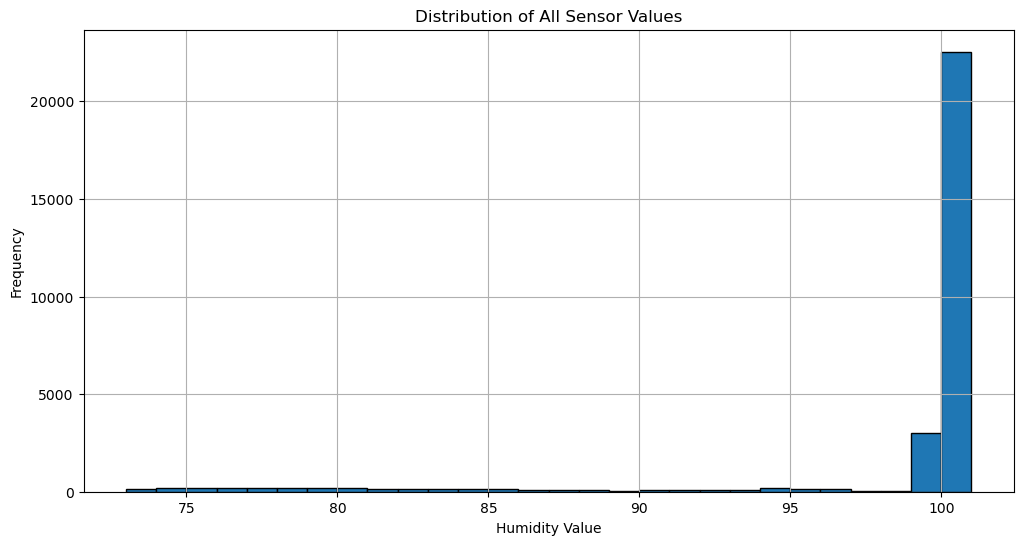

humidity_train shape:(32, 901)
humidity_pred shape:(32, 146)
0 columns in pressure_train are filled with NaN
0 columns in pressure_pred are filled with NaN


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12
x0,1554.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x1,1556.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x2,1558.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x3,1560.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x4,1563.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x5,1567.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x6,1572.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x7,1578.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x8,1585.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
x9,1595.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [24]:
## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
humidity_train = func.fill_NaN_columns(
    K = 5,
    df = humidity_train,
    imputer = imputer,
    coords = coordinates_train
)

humidity_pred = func.fill_NaN_columns(
    K = 5,
    df = humidity_pred,
    imputer = imputer,
    coords = coordinates_pred
)


## Imputing the missing data
humidity_train = (imputer.fit_transform(humidity_train.T)).T
humidity_pred = (imputer.fit_transform(humidity_pred.T)).T


# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Initial shapes
print("humidity_train shape:"+str(humidity_train.shape))
print("humidity_pred shape:"+str(humidity_pred.shape))

## Checking how many columns are filled with NaN values
count = humidity_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')
count = humidity_pred.isnull().all().sum()
print(f'{count} columns in pressure_pred are filled with NaN')


## Imputing the missing data
humidity_train = (imputer.fit_transform(humidity_train.T)).T
humidity_pred = (imputer.fit_transform(humidity_pred.T)).T

display(humidity_train.iloc[:,0:13])

In [25]:
## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
temperature_train = func.fill_NaN_columns(
    K = 5,
    df = temperature_train,
    imputer = imputer,
    coords = coordinates_train
)

## We impute the missing data with the 2 nearest neighbors to view the distribution
temperature_train = (imputer.fit_transform(temperature_train.T)).T 
print(temperature_train.isnull().sum().sum()) # check that it worked

## Applying the filter:
temperature_train.iloc[:,1:] = temperature_train.iloc[:,1:].mask(temperature_train.iloc[:,1:] >= 100, np.nan) ## set filter to 100 to see

## Initial shape: 
print(f'temperature_train shape: {temperature_train.shape}')
print(f'empty columns: {temperature_train.isnull().all().sum()}')

## We impute the missing data with the 2 nearest neighbors as done with the pressure
temperature_train = (imputer.fit_transform(temperature_train.T)).T

## New shape: 
print(f'temperature_train shape: {temperature_train.shape}')

0
temperature_train shape: (32, 901)
empty columns: 0
temperature_train shape: (32, 901)


In [26]:
## Mean and standard deviation are always computed on the training data
## axis = None computes the mean over the entire DataFrame with our current version of pandas: 2.0.3
## but it doesn't work with the std: 
#  https://stackoverflow.com/questions/25140998/pandas-compute-mean-or-std-standard-deviation-over-entire-dataframe

pressure_mean = pressure_train.iloc[:,1:].mean(axis=None) 
pressure_std = pressure_train.iloc[:,1:].values.std()

humidity_mean = humidity_train.iloc[:,1:].mean(axis=None) 
humidity_std = humidity_train.iloc[:,1:].values.std()

temperature_mean = temperature_train.iloc[:,1:].mean(axis=None)
temperature_std = temperature_train.iloc[:,1:].values.std()

coordinates_mean = coordinates_train[["x","y","z","r"]].mean(axis=0)
coordinates_std = coordinates_train[["x","y","z","r"]].std(axis=0)

# print(f'Mean pressure: {pressure_mean}')
# print(f'SD of pressure: {pressure_std}')

# print(f'Mean humidity: {humidity_mean}')
# print(f'SD of humidity: {humidity_std}')

# print(f'Mean temperature: {temperature_mean}')
# print(f'SD of temperature: {temperature_std}')

pressure_train.iloc[:,1:] -= pressure_mean
pressure_train.iloc[:,1:] /= pressure_std
pressure_pred.iloc[:,1:] -= pressure_mean
pressure_pred.iloc[:,1:] /= pressure_std

humidity_train.iloc[:,1:] -= humidity_mean
humidity_train.iloc[:,1:] /= humidity_std
humidity_pred.iloc[:,1:] -= humidity_mean
humidity_pred.iloc[:,1:] /= humidity_std

temperature_train.iloc[:,1:] -= temperature_mean
temperature_train.iloc[:,1:] /= temperature_std

coordinates_train[["x","y","z","r"]] -= coordinates_mean
coordinates_train[["x","y","z","r"]] /= coordinates_std
coordinates_pred[["x","y","z","r"]] -= coordinates_mean
coordinates_pred[["x","y","z","r"]] /= coordinates_std

## Check that the values now follow a normal distribution : 
## (the test sets will be off obviously)
assert np.isclose(pressure_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(pressure_train.iloc[:,1:].values.std(), 1)

assert np.isclose(humidity_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(humidity_train.iloc[:,1:].values.std(), 1)

assert np.isclose(temperature_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(temperature_train.iloc[:,1:].values.std(), 1)

assert np.allclose(coordinates_train[["x","y","z","r"]].mean(axis=0), 0)
assert np.allclose(coordinates_train[["x","y","z","r"]].std(axis=0), 1)



In [27]:
display(pressure_train.head(5))
display(humidity_train.head(5))
display(coordinates_train.head(5))
display(temperature_train.head(5))

print(f"Pressure's shape: {pressure_train.shape}")
print(f"Humidity's shape: {humidity_train.shape}")
print(f"Coordinates' shape: {coordinates_train.shape}")
print(f"Temperature's shape: {temperature_train.shape}")

## Verify that we no longer have missing values: 
assert pressure_train.isnull().any().sum() == 0
assert pressure_pred.isnull().any().sum() == 0
assert humidity_train.isnull().any().sum() == 0
assert humidity_pred.isnull().any().sum() == 0
assert coordinates_train.isnull().any().sum() == 0
assert coordinates_pred.isnull().any().sum() == 0
assert temperature_train.isnull().any().sum() == 0

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
x0,1554.0,-0.847722,0.770095,1.191058,0.466211,0.794602,0.809098,1.179652,0.876745,0.629819,...,-1.226018,-1.287189,-1.267811,-0.993575,-1.039232,-1.158717,-0.966897,-1.271279,-1.199328,-0.602027
x1,1556.0,-0.849047,0.768841,1.190983,0.465488,0.794503,0.809022,1.179430,0.876488,0.629262,...,-1.227074,-1.287189,-1.269034,-0.995916,-1.040441,-1.158878,-0.968284,-1.271279,-1.199328,-0.602441
x2,1558.0,-0.850322,0.767577,1.190906,0.464765,0.794403,0.808946,1.179206,0.876227,0.628706,...,-1.228092,-1.287189,-1.270532,-0.998193,-1.041552,-1.159032,-0.969592,-1.271279,-1.199328,-0.602643
x3,1560.0,-0.851538,0.766305,1.190827,0.464043,0.794301,0.808872,1.178980,0.875964,0.628152,...,-1.229057,-1.287189,-1.271948,-1.000352,-1.042497,-1.159181,-0.970797,-1.271279,-1.199328,-0.602547
x4,1563.0,-0.853181,0.764380,1.190705,0.462961,0.794147,0.808762,1.178637,0.875561,0.627323,...,-1.230257,-1.287189,-1.273678,-1.003135,-1.043234,-1.159385,-0.972282,-1.271279,-1.199328,-0.601402


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
x0,1554.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.400404,0.324866,0.324866,0.324866,0.295353,-3.573134,0.268955,0.324866,-3.644863,0.324866
x1,1556.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.398901,0.324866,0.324866,0.324866,0.295323,-3.572826,0.268857,0.324866,-3.529004,0.324866
x2,1558.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.397208,0.324866,0.324866,0.324866,0.295343,-3.572514,0.268761,0.324866,-3.439484,0.324866
x3,1560.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.395231,0.324866,0.324866,0.324866,0.295434,-3.572195,0.268668,0.324866,-3.367152,0.324866
x4,1563.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.391427,0.324866,0.324866,0.324866,0.295757,-3.571681,0.268541,0.324866,-3.282594,0.324866


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_1,0.016937,-1.027975,-0.380302,-0.860992,False,False,False,False,True,False,False
1,N_2,-1.210408,0.141186,-0.016204,0.084301,False,False,False,False,True,False,False
2,N_3,-1.921589,-1.685009,-1.379661,1.435142,False,False,False,False,True,False,False
3,N_4,0.806761,-2.024077,-0.422075,-0.237832,False,False,False,False,True,False,False
4,N_5,0.530507,1.877074,1.497395,0.549192,False,False,False,False,True,False,False


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
x0,1554.0,-0.482682,-0.516202,-0.481358,-0.494647,-0.571554,-0.555474,-0.479869,-0.562762,-0.531245,...,-0.491199,-0.511120,-0.491603,-0.508030,-0.486227,-0.497756,-0.489603,-0.501136,-0.024854,-0.488749
x1,1556.0,-0.482839,-0.516199,-0.481351,-0.494637,-0.569032,-0.555467,-0.479861,-0.562753,-0.531233,...,-0.490710,-0.511264,-0.491582,-0.508104,-0.485837,-0.497926,-0.489846,-0.501228,0.668877,-0.488802
x2,1558.0,-0.483000,-0.516196,-0.481344,-0.494626,-0.569027,-0.555459,-0.479853,-0.562745,-0.531222,...,-0.489043,-0.511232,-0.491346,-0.511105,-0.484384,-0.498064,-0.490039,-0.501214,1.231764,-0.488804
x3,1560.0,-0.483163,-0.519605,-0.481338,-0.494616,-0.569022,-0.555451,-0.479844,-0.562737,-0.531210,...,-0.485645,-0.510902,-0.490789,-0.508187,-0.481448,-0.498146,-0.490140,-0.501025,1.704820,-0.488717
x4,1563.0,-0.483402,-0.516190,-0.481328,-0.494600,-0.569016,-0.555440,-0.479832,-0.562724,-0.531193,...,-0.475497,-0.509374,-0.488952,-0.508085,-0.473063,-0.498053,-0.489929,-0.500124,2.279636,-0.488252


Pressure's shape: (32, 901)
Humidity's shape: (32, 901)
Coordinates' shape: (900, 12)
Temperature's shape: (32, 901)


In [28]:
## Defining a KNN imputer on entire columns:
def KNN(K: int, Sensor_ID: str,data: pd.DataFrame, data_no_nan: pd.DataFrame, coords_train: pd.DataFrame, coords: pd.DataFrame) -> pd.DataFrame: 
    """
    Returns a column with the average values from the K geometrically closest sensors.

    Args: 
        K: Number of neighbors to consider.
        Sensor_ID: The sensor we want to impute.
        data_no_nan: a copy of the data but where NaN values were removed
        coords: The dataframe containing the coordinate informations.

    Returns: 
        A column with the average values from the K geometrically closest sensors
    """

    ## making a disctionnary to easily change from sensor names to indices
    sensor_dic = {i:j for i,j in enumerate(coords_train["id"])}
    ## Selecting the row of the sensor we impute
    ## Caution: the columns have to be already renamed for "id" to be found !
    point = coords[coords["id"] == Sensor_ID]
    ## has to be numpy array for broadcasting
    point = point[["x","y","z"]].to_numpy() 

    ## taking the coordinates of all the other sensors
    all_others = coords_train[["x","y","z"]]

    ## computing the distance of the sensor to all others
    distances = np.sum((all_others - point)**2, axis = 1)

    ## sorting in ascending order
    distances = distances.sort_values()

    sensors = []
    i = 0
    while  len(sensors) < K:

        ## selecting the closest sensor (index 0 is the sensor itself at a distance 0)
        distance = distances.copy().to_list()[i+1] 
        
        ## Converting sensor index back to string
        ## the length of distances.copy().to_list() match with distances.shape[0] so the index is the right one
        assert len(distances.copy().to_list()) == distances.shape[0]
        sensor = sensor_dic[distances[distances == distance].index[0]]

        ## making sure we copy a sensor that has values
        if sensor in data.columns: 
            sensors.append(sensor)

        i += 1

    #try:
    values = data[sensors]
    # except: 
    #     display(data)
    #     print(data.columns.tolist())
    #     # display(data[sensor[0]])
    
    return  1/K * np.sum(values, axis = 1) # return the average

In [45]:
X_t_pred = {}
sensor_IDs = pressure_pred.columns[1:]
# columns = np.array(["id"])
# t = np.array(pressure_pred['M.Time[d]'].to_list(), dtype = np.int32)
# print(columns.shape)
# print(t.shape)
# columns = np.concatenate([columns, t])
# print(columns)
# print(columns.shape)
pred = pd.DataFrame(data = sensor_IDs, columns=["id"])
pred = pred.T

for i, t in enumerate(pressure_pred['M.Time[d]']): 
    ## first, selsect the pressure data at the time
    X = pressure_pred.iloc[i, 1:]
    H = humidity_pred.iloc[i,1:]
    ## then transpose as we need the sensor as rows, not columns
    X = X.T
    H = H.T
    X = np.reshape(X, (X.shape[0], 1)) # for some reason it didn't work without reshaping to (n, 1)
    H = np.reshape(H, (H.shape[0], 1))

    ## then add the coordinates and material features to the array 
    coords = coordinates_pred.iloc[:,1:].to_numpy()
    X = np.concatenate([X,H,coords], axis = 1)
    ## add it to the dictionnary
    X_t_pred[t] = X


predictions = {}  # store each column's predictions
for i, sensor in enumerate(sensor_IDs):

    y_sens = KNN(
        K = 5,
        Sensor_ID = sensor,
        data = temperature_train,
        data_no_nan = imputer.fit_transform(pressure_pred),
        coords_train = coordinates_train,
        coords = coordinates_pred
    )

    y_sens = y_sens*temperature_std + np.ones(y_sens.shape[0])*temperature_mean
    predictions[sensor] = pd.Series(y_sens, name=sensor)

pred = pd.concat(predictions.values(), axis=1)
pred = pred.T
pred.columns = np.array(pressure_pred['M.Time[d]'].tolist(), dtype = np.int32)

display(pred)
pred.to_csv("data\\submission.csv", index=True)

,1554,1556,1558,1560,1563,1567,1572,1578,1585,1595,...,2395,2607,2871,3202,3616,4133,4779,5587,6597,7028
N_901,17.534157,18.175397,18.888841,19.627984,20.731673,22.139419,23.767656,25.529125,27.331320,29.541034,...,54.038671,55.368828,56.561653,57.642440,58.613514,59.700565,60.221138,60.878070,61.444791,61.634119
N_902,17.200093,17.225848,17.199450,17.202250,17.214482,17.249230,17.324566,17.459385,17.668656,18.044209,...,33.720932,35.041324,36.254957,37.379798,38.413419,39.348560,40.192896,40.957755,41.647404,41.885452
N_903,17.542932,17.558902,17.598644,17.666288,17.830535,18.142475,18.633790,19.213216,20.142656,21.334727,...,42.708265,44.086745,45.336093,46.479081,47.515891,48.440841,49.262762,49.992950,50.634127,50.850554
N_904,17.448448,17.446322,17.444441,17.443023,17.442833,17.448040,17.465817,17.505433,17.576186,17.719219,...,25.679094,26.511201,27.326092,28.127241,28.904843,29.644833,30.343375,31.001448,31.616427,31.833453
N_905,17.224406,17.222816,17.221906,17.222176,17.226952,17.244221,17.285977,17.365658,17.494583,17.733274,...,27.863277,28.825054,29.750332,30.645508,31.501962,32.306759,33.058542,33.760576,34.411592,34.640238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N_1042,17.338714,17.444316,17.612989,17.833378,18.247374,18.273424,19.768061,21.158590,22.085006,23.769627,...,47.056992,48.380629,49.579941,49.855568,51.679626,52.576239,53.377791,54.096485,54.737761,54.957903
N_1043,17.377306,17.375465,17.374327,17.374449,17.390211,17.397911,17.442968,17.528749,17.666648,17.918969,...,27.463033,28.352926,29.215549,30.056041,30.865237,31.629593,32.346434,33.017882,33.642114,33.861719
N_1044,17.192513,17.190990,17.190017,17.190017,17.193769,17.208535,17.245808,17.319192,17.440921,17.671858,...,28.193379,29.190269,30.144938,31.064570,31.940873,32.761228,33.525016,34.236231,34.894109,35.124820
N_1045,17.363299,17.342054,17.362267,17.364064,17.373629,17.373798,17.474258,17.606797,17.819549,18.209827,...,32.512749,33.666562,34.746363,35.765224,36.717535,37.592944,38.394655,39.130261,39.801584,40.035058
